<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/rays/cassi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Coded Aperture Snapshot Spectral Imaging
###David Brady
### University of Arizona

Section 4.5 of **Computational Imaging**

### Python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import signal, io
from scipy import integrate
from scipy.linalg import toeplitz
import cv2
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from google.colab import files

In [2]:
!pip install pylops
import pylops

     |████████████████████████████████| 183 kB 5.3 MB/s 


## Forward Model

In [ ]:
t 

here we consider a simple example of 2D coded aperture snapshot spectral imaging. We image the $x\lambda $ plane. 

As an example, we use the Indian Pines data set described by

Baumgardner, M. F., Biehl, L. L., Landgrebe, D. A. (2015). 220 Band AVIRIS Hyperspectral Image Data Set: June 12, 1992 Indian Pine Test Site 3. Purdue University Research Repository. [doi:10.4231/R7RX991C](https://purr.purdue.edu/publications/1947/1)

The data is 2900 meters by 2900 meters with an approximate ground sample distance of 20 meters. There are 220 spectral bands spanning 400 to 2400 nm, the image captures various crops and forests. 



In [3]:
!wget http://www.ehu.eus/ccwintco/uploads/2/22/Indian_pines.mat
pip=io.loadmat('Indian_pines.mat')
data=pip['indian_pines']

--2021-11-09 00:55:54--  http://www.ehu.eus/ccwintco/uploads/2/22/Indian_pines.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6296374 (6.0M)
Saving to: ‘Indian_pines.mat’

Indian_pines.mat    100%[===================>]   6.00M   766KB/s    in 8.4s    

2021-11-09 00:56:03 (732 KB/s) - ‘Indian_pines.mat’ saved [6296374/6296374]



# Spatial View of the data set

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

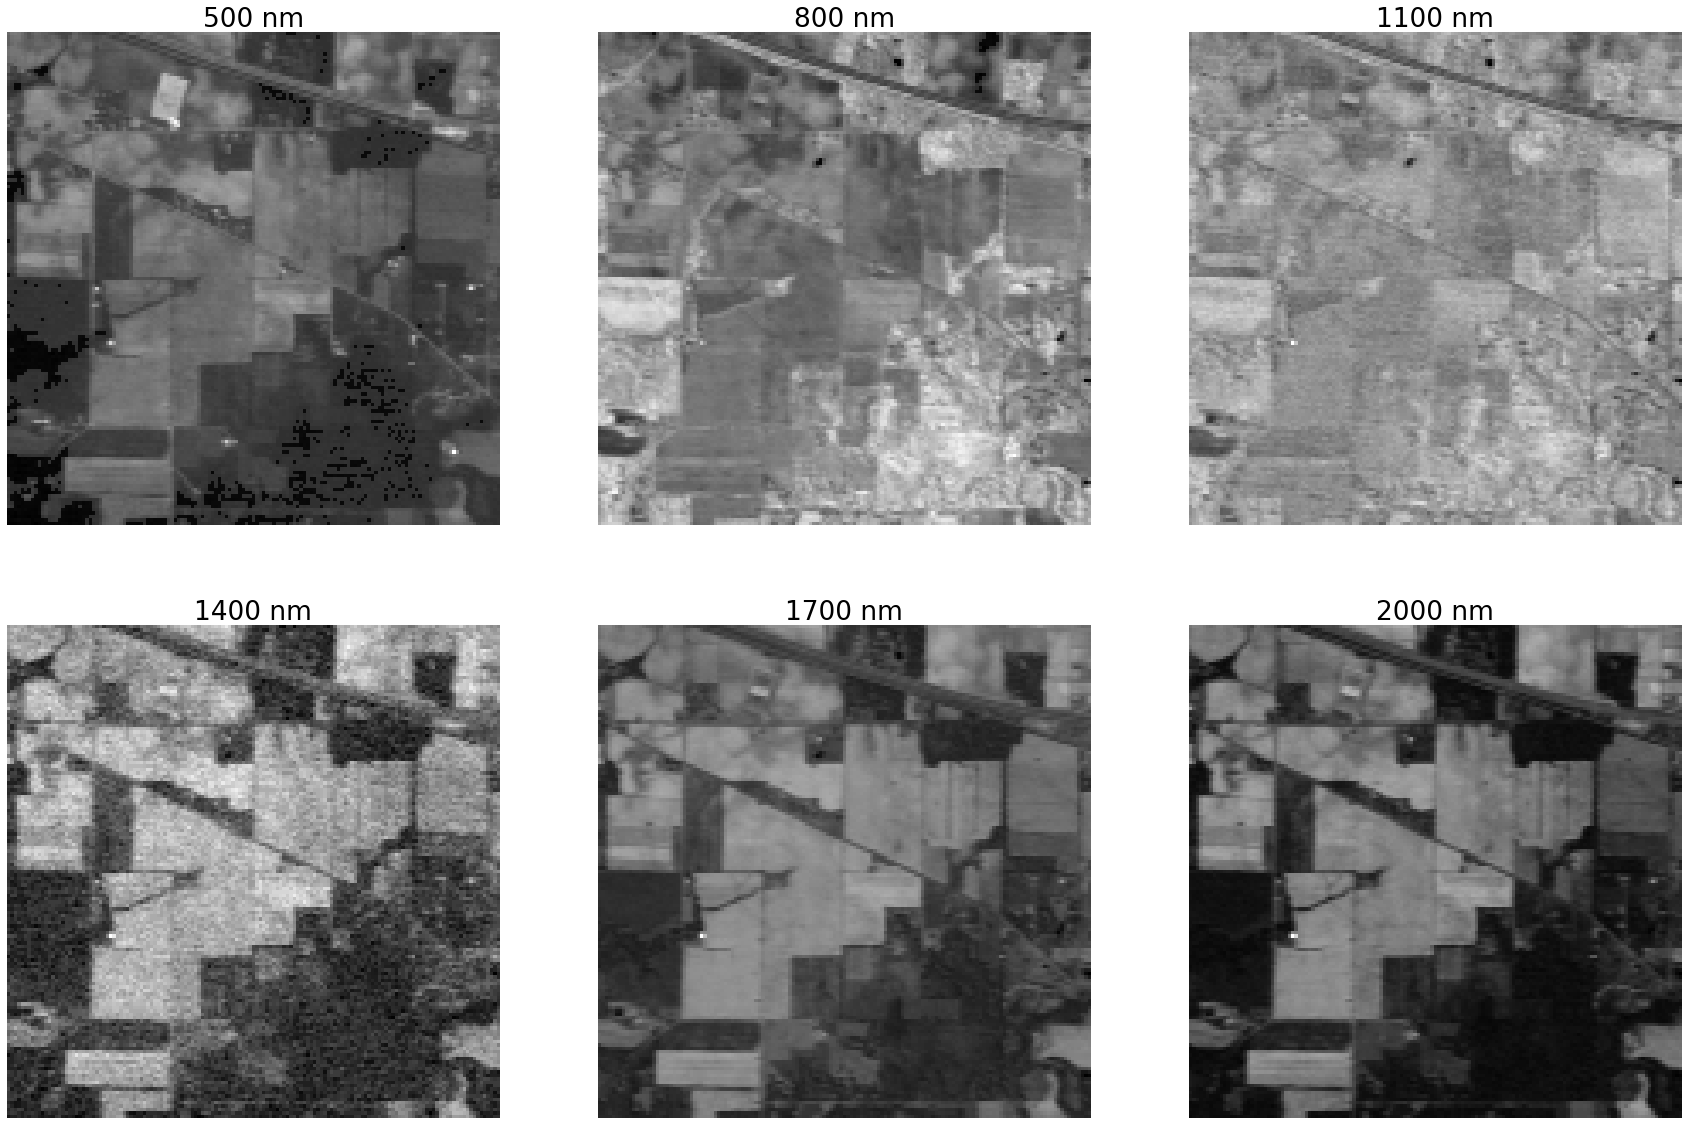

In [ ]:


plt.rcParams['figure.figsize'] = [30, 20]
plt.subplot(2,3,1)
plt.imshow(data[:,:,11], extent=[0,2900,0,2900], cmap='gray')
plt.axis('off')
plt.title('500 nm')
plt.subplot(2,3,2)
plt.imshow(data[:,:,44], extent=[0,2900,0,2900], cmap='gray')
plt.axis('off')
plt.title('800 nm')
plt.subplot(2,3,3)
plt.imshow(data[:,:,77], extent=[0,2900,0,2900], cmap='gray')
plt.axis('off')
plt.title('1100 nm')
plt.subplot(2,3,4)
plt.imshow(data[:,:,110], extent=[0,2900,0,2900], cmap='gray')
plt.axis('off')
plt.title('1400 nm')
plt.subplot(2,3,5)
plt.imshow(data[:,:,143], extent=[0,2900,0,2900], cmap='gray')
plt.axis('off')
plt.title('1700 nm')
plt.subplot(2,3,6)
plt.imshow(data[:,:,176], extent=[0,2900,0,2900], cmap='gray')
plt.axis('off')
plt.title('2000 nm')

plt.savefig('indianPinesSpatial.pdf')
files.download('indianPinesSpatial.pdf')

## Spectral view of data set

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

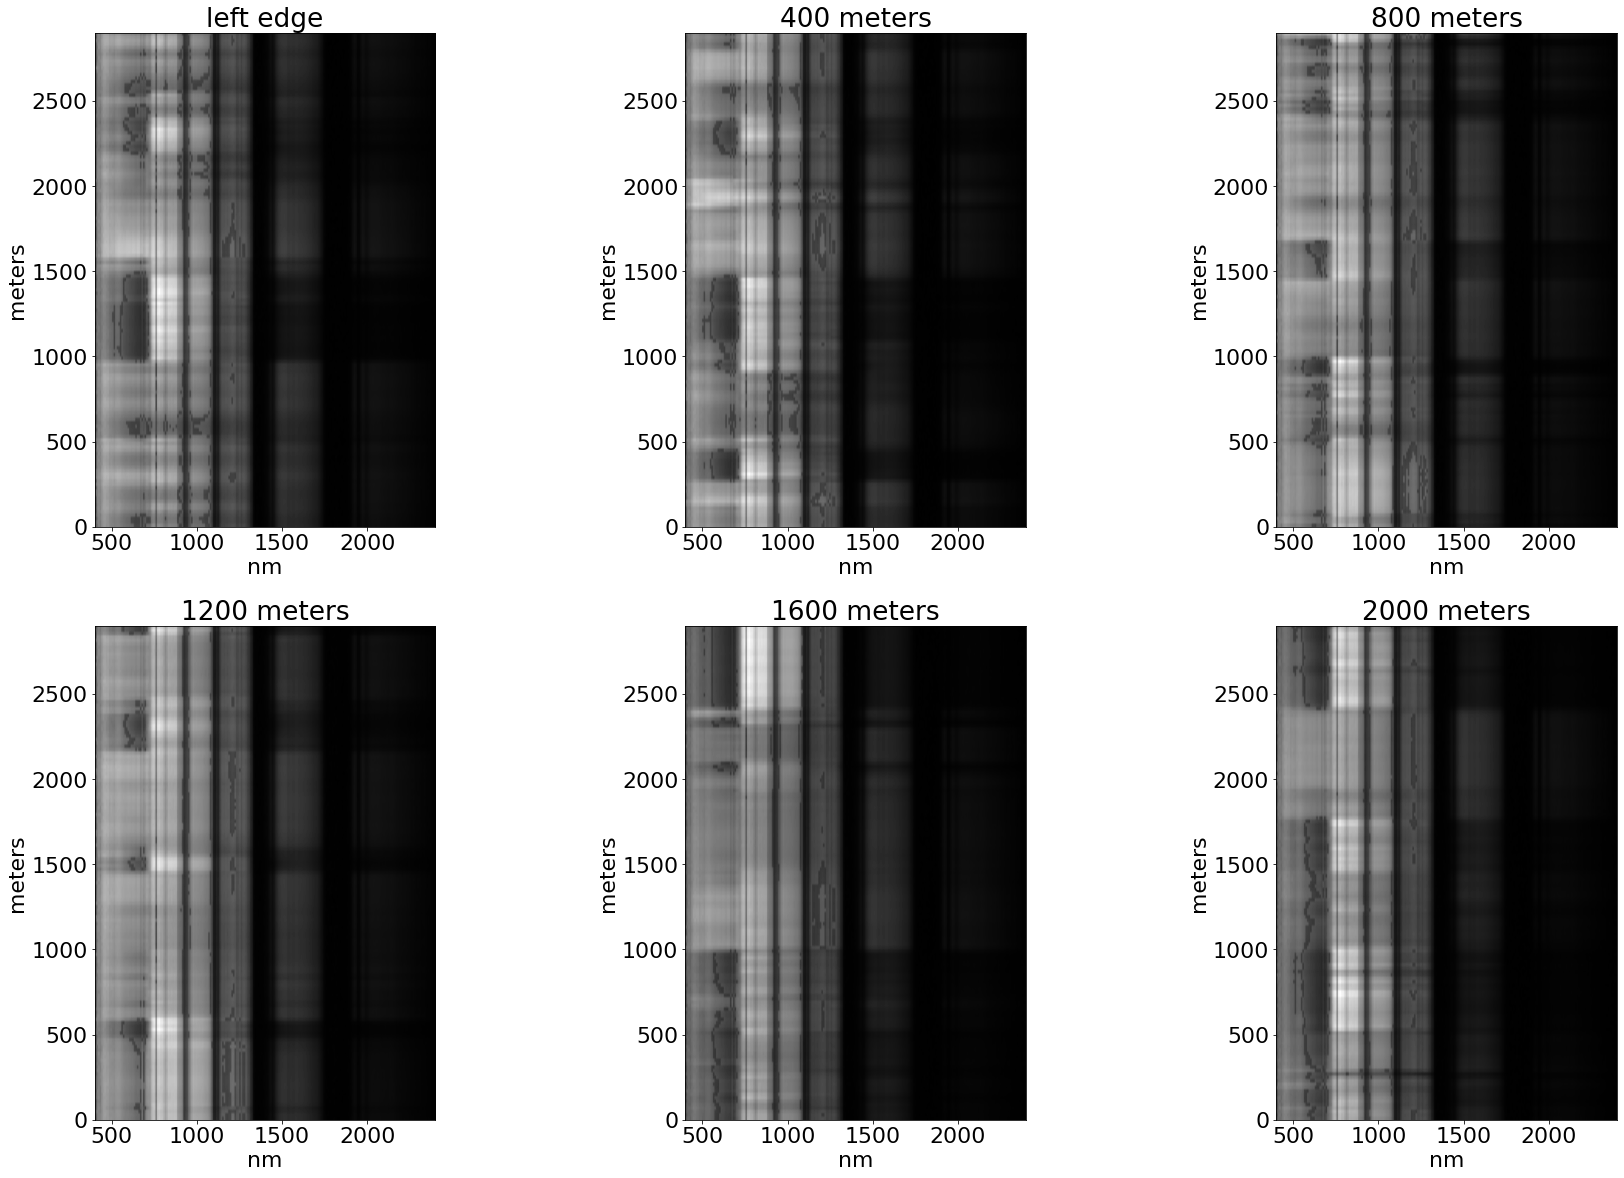

In [ ]:
plt.rcParams['figure.figsize'] = [30, 20]
plt.subplot(2,3,1)
plt.imshow(data[0,:,:], extent=[400,2400,0,2900], cmap='gray')
plt.xlabel('nm')
plt.ylabel('meters')
plt.title('left edge')
plt.subplot(2,3,2)
plt.imshow(data[20,:,:], extent=[400,2400,0,2900], cmap='gray')
plt.xlabel('nm')
plt.ylabel('meters')
plt.title('400 meters')
plt.subplot(2,3,3)
plt.imshow(data[40,:,:], extent=[400,2400,0,2900], cmap='gray')
plt.xlabel('nm')
plt.ylabel('meters')
plt.title('800 meters')
plt.subplot(2,3,4)
plt.imshow(data[60,:,:], extent=[400,2400,0,2900], cmap='gray')
plt.xlabel('nm')
plt.ylabel('meters')
plt.title('1200 meters')
plt.subplot(2,3,5)
plt.imshow(data[80,:,:], extent=[400,2400,0,2900], cmap='gray')
plt.xlabel('nm')
plt.ylabel('meters')
plt.title('1600 meters')
plt.subplot(2,3,6)
plt.imshow(data[100,:,:], extent=[400,2400,0,2900], cmap='gray')
plt.xlabel('nm')
plt.ylabel('meters')
plt.title('2000 meters')

plt.savefig('indianPinesSpectral.pdf')
files.download('indianPinesSpectral.pdf')

## Measurement with a coded aperture

With a coded aperture spectral imager, the scene is first imaged  on to a code and then sheared by a dispersive element before measurement. Here the scene has 145 spatial pixels, so the code will also have 145 pixels. 

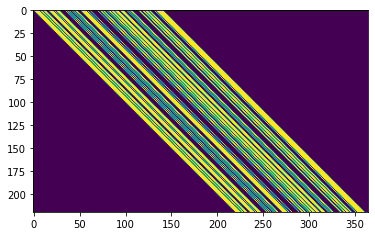

In [4]:
code=np.random.randint(0,2,145)
r=np.zeros(220+145)
r[0:145]=code
c=np.zeros(220)
c[0]=r[0]
H=toeplitz(c,r)
plt.imshow(H)



First measurement is spatial element one, spectral element 1 multiplied by code element one. Second meaurement is x2 s1 t2 + x1 s2 t1. third is x3 s1 t3 + x2 t2 s2 + x1 t1 s3


for Nl spectral channels and Nx spatial channels, assume one pixel shift in the spatial channels in each measurement. The measurement matrix is a $Nl\times Nx$ by $Nl+Nx$ matrix. Let the plane be rastered in Nl elements each Nx elements long. The code multiplies the each of the Nx elements. Then one element is taken from each of the spectral bands in a shifting form.
$$g_n=\sum_{i=0}^{n} S_{i,n-i}t_{n-i}$$
or $h_{ij}=0$ except
$$h_{n,i*n-i}=t_{n-i}$$


In [ ]:
Nl=64
Nx=145
H=np.zeros((Nl+Nx,Nl*Nx))
for l in range(1,Nl+Nx+1):
  for ll in range(np.maximum(l-Nx,0),np.minimum(l,Nl)):
    H[l,ll*Nx+l-ll-1]=code[l-ll-1]

code1=np.random.randint(0,2,145)
H1=np.zeros((Nl+Nx,Nl*Nx))
for l in range(1,Nl+Nx+1):
  for ll in range(np.maximum(l-Nx,0),np.minimum(l,Nl)):
    H1[l,ll*Nx+l-ll-1]=code1[l-ll-1]
H=np.vstack((H,H1))
code1=np.random.randint(0,2,145)
H1=np.zeros((Nl+Nx,Nl*Nx))
for l in range(1,Nl+Nx+1):
  for ll in range(np.maximum(l-Nx,0),np.minimum(l,Nl)):
    H1[l,ll*Nx+l-ll-1]=code1[l-ll-1]
H=np.vstack((H,H1))
code1=np.random.randint(0,2,145)
H1=np.zeros((Nl+Nx,Nl*Nx))
for l in range(1,Nl+Nx+1):
  for ll in range(np.maximum(l-Nx,0),np.minimum(l,Nl)):
    H1[l,ll*Nx+l-ll-1]=code1[l-ll-1]
H=np.vstack((H,H1))
H=np.vstack((H,H1))
code1=np.random.randint(0,2,145)
H1=np.zeros((Nl+Nx,Nl*Nx))
for l in range(1,Nl+Nx+1):
  for ll in range(np.maximum(l-Nx,0),np.minimum(l,Nl)):
    H1[l,ll*Nx+l-ll-1]=code1[l-ll-1]
H=np.vstack((H,H1))



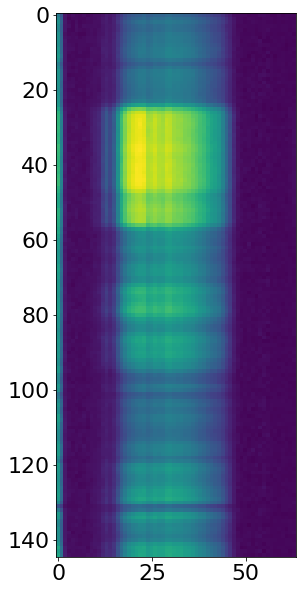

In [ ]:
dx = data[100,:,100:(100+Nl)]
#x = cv2.resize(x, (32,145), interpolation = cv2.INTER_AREA)
x = x/x.max()
ny, nx = x.shape
plt.imshow(x)


## Total Variation Inversion

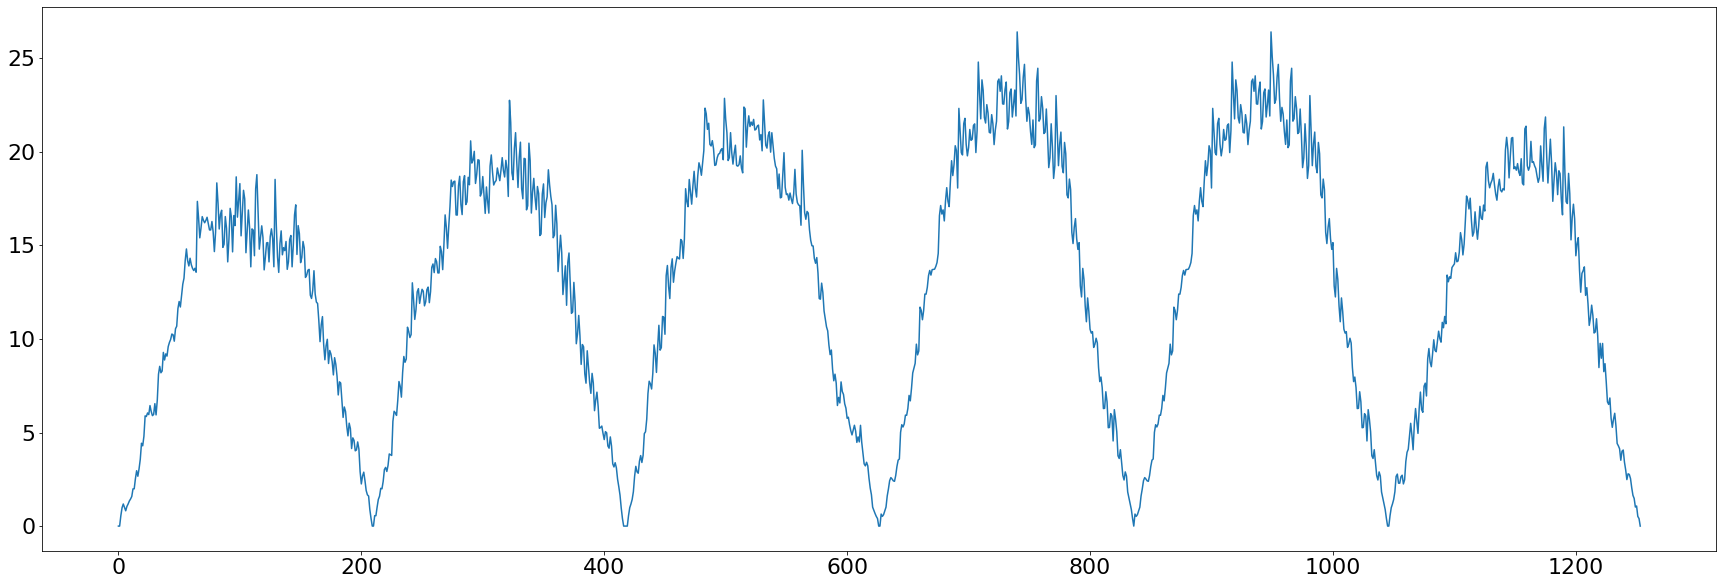

In [ ]:

n = np.random.normal(0, 0., (ny, nx))
y = np.matmul(H,(x.flatten()+n.flatten()))

plt.plot(y)

(-0.5, 63.5, 144.5, -0.5)

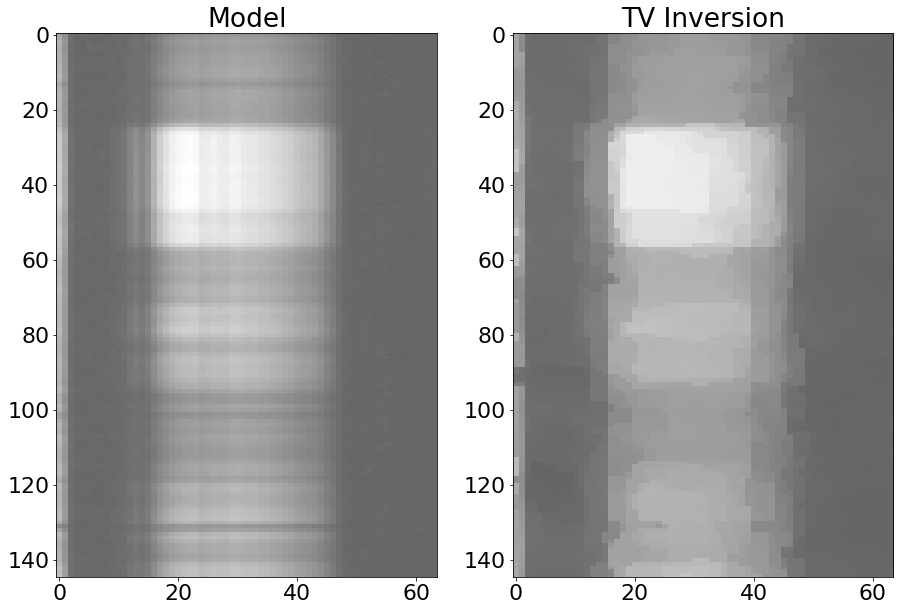

In [ ]:
Dop = \
    [pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=0, edge=False,
                            kind='backward'),
     pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=1, edge=False,
                            kind='backward')]


# TV
mu = .5
lamda = [.1, .1]
niter = 30
niterinner = 10

xinv, niter = \
    pylops.optimization.sparsity.SplitBregman(H, Dop, y,
                                              niter, niterinner,
                                              mu=mu, epsRL1s=lamda,
                                              tol=1e-4, tau=1., show=False,
                                              **dict(iter_lim=5, damp=1e-4))
xinv = np.real(xinv.reshape(ny, nx))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(x, vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(xinv, vmin=0, vmax=1, cmap='gray')
axs[1].set_title('TV Inversion')
axs[1].axis('tight')
